####Analytics Vidya</b>
###Face detection and counting</p></b>
<p>People detection and head counting is one of the classical albeit challenging computer vision application. For this problem, given a group selfie/photo, you are required to count the number of heads present in the picture. You are provided with a training set of images with coordinates of bounding box and head count for each image and need to predict the headcount for each image in the test set.</p></br>

In [ ]:
from google.colab import drive
import zipfile as zip1
import os
drive.mount('/content/drive')
zip_ref = zip1.ZipFile('./drive/My Drive/Colab Notebooks/AnalyticsVidya/train_HNzkrPW (1).zip', 'r')
zip_ref.extractall('train/')
zip_ref.close()

Mounted at /content/drive


Found 5733 validated image filenames.


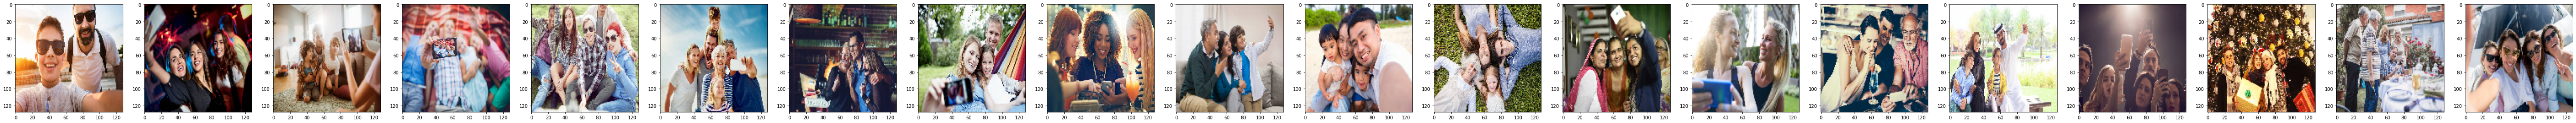

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
IMG_SIZE=128
generator = traindatagen.flow_from_dataframe(traincsv, directory='train/image_data/',x_col='Name', y_col=['Name','HeadCount'],
                                               target_size=(IMG_SIZE,IMG_SIZE), color_mode='rgb',class_mode='raw', batch_size=32,shuffle=True, seed=10)
x_train,yy = next(generator)
fig,ax = plt.subplots(1,20,figsize=(100,5))
for pi in range(20):
  img_to_show = x_train[pi]
  ax[pi].imshow(img_to_show)
plt.show()

In [ ]:
import numpy as np
def get_iou(a,img_size, epsilon=1e-5):
    a[:,9] = np.maximum(a[:,1], a[:,5])
    a[:,10] = np.maximum(a[:,2], a[:,6])
    a[:,11] = np.minimum(a[:,3], a[:,7])
    a[:,12] = np.minimum(a[:,4], a[:,8])
    overlap = np.multiply(np.maximum(0,np.subtract(a[:,11],a[:,9])),np.maximum(0,np.subtract(a[:,12],a[:,10])))
    area_a = np.multiply(np.subtract(a[:,3],a[:,1]),np.subtract(a[:,4],a[:,2]))
    area_b = np.multiply(np.subtract(a[:,7],a[:,5]),np.subtract(a[:,8],a[:,6]))
    area_combined = np.subtract(area_a+area_b,overlap)+epsilon
    a[:,13] = np.divide(overlap,area_combined)*img_size
    a[np.where(a[:,13] > 0),14] = img_size 
    a[np.where(a[:,13] <= 0),14] = 0
    return a
def get_iou_tf(a, epsilon=1e-5):
  a1max = tf.maximum(a[:,0], a[:,4])
  a2max = tf.maximum(a[:,1], a[:,5])
  a3min = tf.minimum(a[:,2], a[:,6])
  a4min = tf.minimum(a[:,3], a[:,7])
  overlap = tf.multiply(tf.maximum(0.0,tf.subtract(a3min,a1max)),tf.maximum(0.0,tf.subtract(a4min,a2max)))
  area_a = tf.multiply(tf.subtract(a[:,2],a[:,0]),tf.subtract(a[:,3],a[:,1]))
  area_b = tf.multiply(tf.subtract(a[:,6],a[:,4]),tf.subtract(a[:,7],a[:,5]))
  area_combined = tf.add(tf.subtract(tf.add(area_a,area_b),overlap),epsilon)
  return tf.divide(overlap,area_combined)

In [ ]:
def getAnchorBasedSlidingWindow(image_size,anchor):
  array = []
  for i in range(0,image_size,anchor):
    for j in range(0,image_size,anchor):
      array.append([i,j,i+anchor,j+anchor])
  return array

def getallSlidingwindows(image_size):
  window8 = np.array(getAnchorBasedSlidingWindow(image_size,8))
  window16 = np.array(getAnchorBasedSlidingWindow(image_size,16))
  window32 = np.array(getAnchorBasedSlidingWindow(image_size,32))
  window64 = np.array(getAnchorBasedSlidingWindow(image_size,64))

  return np.vstack([np.hstack([np.ones(shape=(window8.shape[0],1))*8,window8]),
            np.hstack([np.ones(shape=(window16.shape[0],1))*16,window16]),
            np.hstack([np.ones(shape=(window32.shape[0],1))*32,window32]),
            np.hstack([np.ones(shape=(window64.shape[0],1))*64,window64])])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

traindatagen = ImageDataGenerator(rescale=1./255)
traincsv = pd.read_csv('train/train.csv',dtype={'Name': str,'HeadCount':int})
trainFaceMaskmain = pd.read_csv('train/bbox_train.csv',dtype={'Name': str,'width':float,'height':float,'xmin':float,'ymin':float,'xmax':float,'ymax':float})
def getfaceMaskCSV(img_size):
  trainFaceMaskcsv = pd.DataFrame.copy(trainFaceMaskmain)
  trainFaceMaskcsv['xmin'] = trainFaceMaskcsv['xmin']*img_size/trainFaceMaskcsv['width']
  trainFaceMaskcsv['xmax'] = trainFaceMaskcsv['xmax']*img_size/trainFaceMaskcsv['width']
  trainFaceMaskcsv['ymin'] = trainFaceMaskcsv['ymin']*img_size/trainFaceMaskcsv['height']
  trainFaceMaskcsv['ymax'] = trainFaceMaskcsv['ymax']*img_size/trainFaceMaskcsv['height']
  return trainFaceMaskcsv

def get_faceMasks(traingenerator,trainFaceMaskcsv,img_size):
  while True:
    batch_x, batch_y = next(traingenerator)
    allwin = getallSlidingwindows(img_size)
    facemasks8 = np.zeros(shape=(batch_y.shape[0],int(img_size/8),int(img_size/8),7))
    facemasks16 = np.zeros(shape=(batch_y.shape[0],int(img_size/16),int(img_size/16),7))
    facemasks32 = np.zeros(shape=(batch_y.shape[0],int(img_size/32),int(img_size/32),7))
    facemasks64 = np.zeros(shape=(batch_y.shape[0],int(img_size/64),int(img_size/64),7))
    onestemp = np.ones(shape=(allwin.shape[0]),dtype=np.float64)
    for i in range(batch_y.shape[0]):
      faceList = trainFaceMaskcsv.where(trainFaceMaskcsv['Name']==batch_y[i][0])
      faceList = faceList[faceList.Name.notnull()]
      arr = []
      for face in range(faceList['Name'].count()):
        arr.append(np.concatenate([allwin,np.stack([onestemp*faceList['xmin'].iloc[face],onestemp*faceList['ymin'].iloc[face],onestemp*faceList['xmax'].iloc[face],onestemp*faceList['ymax'].iloc[face],
                                    onestemp*0,onestemp*0,onestemp*0,onestemp*0,onestemp*0,onestemp*0,onestemp*faceList['Name'].count()],axis=1)],axis=1))
      ious = get_iou(np.array(arr).reshape(faceList['Name'].count()*allwin.shape[0],16),img_size=img_size)
      ious2 = pd.DataFrame(ious)
      idx = ious2.loc[ious2.reset_index().groupby([0,1,2,3,4])[13].idxmax()]
      idxarray = np.array(idx)
      facemasks8[i] = np.reshape((idxarray[idxarray[:,0]==8][:,1:16]/img_size)[:,[8,9,10,11,12,13,14]],newshape=(int(img_size/8),int(img_size/8),7))
      facemasks16[i] = np.reshape((idxarray[idxarray[:,0]==16][:,1:16]/img_size)[:,[8,9,10,11,12,13,14]],newshape=(int(img_size/16),int(img_size/16),7))
      facemasks32[i] = np.reshape((idxarray[idxarray[:,0]==32][:,1:16]/img_size)[:,[8,9,10,11,12,13,14]],newshape=(int(img_size/32),int(img_size/32),7))
      facemasks64[i] = np.reshape((idxarray[idxarray[:,0]==64][:,1:16]/img_size)[:,[8,9,10,11,12,13,14]],newshape=(int(img_size/64),int(img_size/64),7))
    yield batch_x, [facemasks8.astype('float32'),facemasks16.astype('float32'),facemasks32.astype('float32'),facemasks64.astype('float32')]

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.layers import (Flatten,LeakyReLU,AveragePooling2D,concatenate,
                                            Reshape,Activation,Input, Conv2D, MaxPooling2D,
                                            BatchNormalization, GlobalAveragePooling2D,SpatialDropout2D)
def resNetBlock(input_image,num):
  layerm = Conv2D(64, 3, strides=(1,1), padding='same', use_bias=False,name ='rone'+str(num))(input_image)
  layerm = BatchNormalization()(layerm)
  layerm = LeakyReLU(alpha=0.1)(layerm)
  layerp = Conv2D(128, 3, strides=(1,1), padding='same', use_bias=False,name ='rp'+str(num))(layerm)
  layerp = BatchNormalization()(layerp)
  layerp = LeakyReLU(alpha=0.1)(layerp)
  layerq = Conv2D(256, 3, strides=(1,1), padding='same', use_bias=False,name ='rq'+str(num))(layerp)
  layerq = BatchNormalization()(layerq)
  layerq = LeakyReLU(alpha=0.1)(layerq) 
  return layerq  

def build_model(img_size,chnl):
  input_sh = Input(shape=(img_size,img_size,chnl)) 
  layer_1 = Conv2D(16, 3, strides=(1,1), padding='same', use_bias=False,name='one')(input_sh)
  layer_1 = BatchNormalization()(layer_1)
  layer_1 = LeakyReLU(alpha=0.1)(layer_1)
  layer_2 = Conv2D(32, 3, strides=(1,1), padding='same', use_bias=False,name='two')(layer_1)
  layer_2 = BatchNormalization()(layer_2)
  layer_2 = LeakyReLU(alpha=0.1)(layer_2)
 
  resNetBlock1 = resNetBlock(layer_2,1)
  concact1 = concatenate([resNetBlock1, layer_2])
  maxpool1 = MaxPooling2D(pool_size=(2, 2))(concact1)    #64
  layer_3 = Conv2D(16, 1, strides=(1,1), padding='same', use_bias=False,name='three')(maxpool1)

  resNetBlock2 = resNetBlock(layer_3,2)
  concact2 = concatenate([resNetBlock2, layer_3])
  maxpool2 = MaxPooling2D(pool_size=(2, 2))(concact2)     #32
  layer_4 = Conv2D(16, 1, strides=(1,1), padding='same', use_bias=False,name='four')(maxpool2)

  resNetBlock3 = resNetBlock(layer_4,3)
  concact3 = concatenate([resNetBlock3, layer_4])
  maxpool3 = MaxPooling2D(pool_size=(2, 2))(concact3)     #16
  layer_5 = Conv2D(16, 1, strides=(1,1), padding='same', use_bias=False,name='five')(maxpool3)
  
  resNetBlock4 = resNetBlock(layer_5,4)
  layer_6 = Conv2D(32, 3, strides=(1,1), padding='same', use_bias=False,name='six')(resNetBlock4)
  layer_6 = LeakyReLU(alpha=0.1)(layer_6)
  layer_6 = BatchNormalization()(layer_6)
  output_op1 = Conv2D(7, 1, strides=(1,1), padding='same', use_bias=False,name='op1')(layer_6)
  concact4 = concatenate([resNetBlock4, layer_5])
  maxpool4 = MaxPooling2D(pool_size=(2, 2))(concact4)    #8
  layer_7 = Conv2D(16, 1, strides=(1,1), padding='same', use_bias=False,name='seven')(maxpool4)

  resNetBlock5 = resNetBlock(layer_7,5)
  layer_8 = Conv2D(32, 3, strides=(1,1), padding='same', use_bias=False,name='eight')(resNetBlock5)
  layer_8 = LeakyReLU(alpha=0.1)(layer_8)
  layer_8 = BatchNormalization()(layer_8)
  output_op2 = Conv2D(7, 1, strides=(1,1), padding='same', use_bias=False,name='op2')(layer_8)
  concact5 = concatenate([resNetBlock5, layer_7])
  maxpool5 = MaxPooling2D(pool_size=(2, 2))(concact5)     #4
  layer_9 = Conv2D(16, 1, strides=(1,1), padding='same', use_bias=False,name='nine')(maxpool5)

  resNetBlock6 = resNetBlock(layer_9,6)
  layer_10 = Conv2D(32, 3, strides=(1,1), padding='same', use_bias=False,name='ten')(resNetBlock6)
  layer_10 = LeakyReLU(alpha=0.1)(layer_10)
  layer_10 = BatchNormalization()(layer_10)
  output_op3 = Conv2D(7, (1,1), strides=(1,1), padding='same', use_bias=False, name='op3')(layer_10)
  concact6 = concatenate([resNetBlock6, layer_9])
  maxpool5 = MaxPooling2D(pool_size=(2, 2))(concact6)     #2
  layer_11 = Conv2D(16, 1, strides=(1,1), padding='same', use_bias=False,name='eleven')(maxpool5)

  resNetBlock7 = resNetBlock(layer_11,7)
  layer_12 = Conv2D(32, 3, strides=(1,1), padding='same', use_bias=False,name='twelve')(resNetBlock7)
  layer_12 = LeakyReLU(alpha=0.1)(layer_12)
  layer_12 = BatchNormalization()(layer_12)
  output_op4 = Conv2D(7, (1,1), strides=(1,1),padding='same', use_bias=False, name='op4')(layer_12)
  model = tf.keras.Model(input_sh,outputs=[output_op1,output_op2,output_op3,output_op4])
  return model

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.28.17.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.28.17.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
import tensorflow_addons as tfa
with strategy.scope():
  gl = tfa.losses.GIoULoss(reduction=tf.keras.losses.Reduction.NONE)
  bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE,from_logits=True)
  mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
  mseMetric = tf.keras.metrics.MeanSquaredError()
  classifiMetric = tf.keras.metrics.BinaryCrossentropy()

  def reshape_things(labels, predictions):
    shape1 = (labels[0].shape[0]*labels[0].shape[1]*labels[0].shape[2],labels[0].shape[3])
    shape2 = (labels[1].shape[0]*labels[1].shape[1]*labels[1].shape[2],labels[1].shape[3])
    shape3 = (labels[2].shape[0]*labels[2].shape[1]*labels[2].shape[2],labels[2].shape[3])
    shape4 = (labels[3].shape[0]*labels[3].shape[1]*labels[3].shape[2],labels[3].shape[3])
    labels_shaped = tf.clip_by_value(tf.concat([tf.reshape(labels[0],shape=shape1),tf.reshape(labels[1],shape=shape2),tf.reshape(labels[2],shape=shape3),
                               tf.reshape(labels[3],shape=shape4)],axis=0),0,1)
    predictions_shaped = tf.clip_by_value(tf.concat([tf.reshape(predictions[0],shape=shape1),tf.reshape(predictions[1],shape=shape2),
                                                     tf.reshape(predictions[2],shape=shape3),tf.reshape(predictions[3],shape=shape4)],axis=0),0,1)

    classifylabel = tf.reshape(labels_shaped[:,5],shape=(labels_shaped[:,5].shape[0],1))
    classifypred = tf.reshape(predictions_shaped[:,5],shape=(predictions_shaped[:,5].shape[0],1))
    #classifylabelnorm = tf.divide(tf.subtract(classifylabel,tf.reduce_min(classifylabel)),tf.subtract(tf.reduce_max(classifylabel),tf.reduce_min(classifylabel)))
    #classifyprednorm = tf.divide(tf.subtract(classifypred,tf.reduce_min(classifypred)),tf.subtract(tf.reduce_max(classifypred),tf.reduce_min(classifypred)))
    bc1 = tf.concat([classifylabel,tf.abs(tf.subtract(classifylabel,tf.ones(classifylabel.shape)))],axis=1)
    bc2 = tf.concat([classifypred,tf.abs(tf.subtract(classifypred,tf.ones(classifypred.shape)))],axis=1)
    mselabel = tf.concat([tf.reshape(labels_shaped[:,4],shape=(labels_shaped[:,6].shape[0],1)),tf.reshape(labels_shaped[:,6],shape=(labels_shaped[:,6].shape[0],1))],axis=1)
    msepred = tf.concat([tf.reshape(predictions_shaped[:,4],shape=(predictions_shaped[:,6].shape[0],1)),tf.reshape(predictions_shaped[:,6],shape=(predictions_shaped[:,6].shape[0],1))],axis=1)
    ioulabel = tf.reshape(labels_shaped[:,0:4],shape=(labels_shaped[:,0:4].shape[0],4))
    ioupred = tf.reshape(predictions_shaped[:,0:4],shape=(predictions_shaped[:,0:4].shape[0],4))
    return bc1,bc2,mselabel,msepred,ioulabel,ioupred,classifylabel

  def compute_loss(labels, predictions):
    bc1,bc2,mselabel,msepred,ioulabel,ioupred,classifylabel = reshape_things(labels, predictions)
    p1 = bce(bc1,bc2)
    p2 = mse(mselabel,msepred)
    p3 = gl(ioulabel,ioupred)
    pp11 = tf.nn.compute_average_loss(p1)
    pp22 = tf.nn.compute_average_loss(p2 *classifylabel)
    pp33 = tf.nn.compute_average_loss(p3* classifylabel)
    return pp11/2.0,pp22,pp33

  def custom_metric(labels,predictions):
    bc1,bc2,mselabel,msepred,ioulabel,ioupred,classifylabel = reshape_things(labels, predictions)
    classifiMetric.update_state(bc1,bc2)
    mseMetric.update_state(mselabel,msepred)
    iou = get_iou_tf(tf.concat([ioulabel,ioupred],1))
    return tf.math.reduce_mean(iou*classifylabel)
    
  def custom_metric_reset():
    return classifiMetric.reset_states(),mseMetric.reset_states()
  def custom_metric_result():
    return classifiMetric.result(),mseMetric.result()

In [ ]:
from tensorflow.data import Dataset
from tensorflow.python.keras.callbacks import ModelCheckpoint
def train_step(input):
  image,[label1,label2,label3,label4] = input
  with tf.GradientTape() as tape:
    predictions1,predictions2,predictions3,predictions4 = model(image, training=True)
    l1,l2,l3 = compute_loss([label1,label2,label3,label4],[predictions1,predictions2,predictions3,predictions4])
  gradients = tape.gradient([l1,l2,l3], model.trainable_variables)
  updated_vars = optimizer.apply_gradients(list(zip(gradients,model.trainable_variables)))
  iou = custom_metric([label1,label2,label3,label4],[predictions1,predictions2,predictions3,predictions4])
  return l1,l2,l3,iou

@tf.function
def distributed_train_epoch(xx,yy):
  l1,l2,l3,iou = strategy.run(train_step,args=((xx,yy),))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, l1, axis=None),strategy.reduce(tf.distribute.ReduceOp.SUM, l2, axis=None),strategy.reduce(tf.distribute.ReduceOp.SUM, l3, axis=None),strategy.reduce(tf.distribute.ReduceOp.SUM, iou, axis=None)

def custom_loop(img_size,initial_epoch,num_epochs,batch_size):
  num_batches = int(5733/batch_size)
  trainFaceMaskcsv = getfaceMaskCSV(img_size)
  generator = traindatagen.flow_from_dataframe(traincsv, directory='train/image_data/',x_col='Name', y_col=['Name','HeadCount'],
                                               target_size=(img_size,img_size), color_mode='rgb',class_mode='raw', batch_size=batch_size,shuffle=True, seed=10)
  for epoch in range(initial_epoch,num_epochs):
    total_loss=0.0
    total_metric = 0.0
    iou_per_epoch = 0.0
    for batch in range(num_batches):
      xx,[m1,m2,m3,m4] = next(get_faceMasks(generator,trainFaceMaskcsv,img_size))
      l1,l2,l3,iou = distributed_train_epoch(xx,[m1,m2,m3,m4])
      total_loss += l1+l2+l3
      iou_per_epoch += iou
    f1,f2 = custom_metric_result()
    total_metric = (f1 +(iou_per_epoch/num_batches))/2 
    custom_metric_reset()
    template = ('Epoch: {} ->  Train Loss: {:.6f}, facecount_regress_mse:{:.6f}      Train Accuracy: {:.6f},classification Accuracy: {:.6f}, iou_accuracy: {:.6f}')
    print(template.format(epoch,total_loss/num_batches,f2, total_metric,f1,iou_per_epoch*2.0/num_batches))
  model.save_weights('drive/My Drive/Colab Notebooks/AnalyticsVidya/FaceDetection/face_detectionTPUclip'+str(initial_epoch)+'_'+str(num_epochs)+'.hdf5')

In [ ]:
with strategy.scope():
  model = build_model(64,3)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
custom_loop(64,0,20,batch_size=64)

Found 5733 validated image filenames.
Epoch: 0 ->  Train Loss: 1864.981689, facecount_regress_mse:0.079157      Train Accuracy: 0.172530,classification Accuracy: 0.680596, iou_accuracy: 0.009523
Epoch: 1 ->  Train Loss: 1629.572632, facecount_regress_mse:0.009072      Train Accuracy: 0.165988,classification Accuracy: 0.635509, iou_accuracy: 0.028445
Epoch: 2 ->  Train Loss: 1615.728027, facecount_regress_mse:0.007315      Train Accuracy: 0.193100,classification Accuracy: 0.729003, iou_accuracy: 0.043397
Epoch: 3 ->  Train Loss: 1609.404785, facecount_regress_mse:0.006998      Train Accuracy: 0.244177,classification Accuracy: 0.913435, iou_accuracy: 0.063272
Epoch: 4 ->  Train Loss: 1611.315308, facecount_regress_mse:0.006150      Train Accuracy: 0.261435,classification Accuracy: 0.987777, iou_accuracy: 0.057962
Epoch: 5 ->  Train Loss: 1610.155151, facecount_regress_mse:0.006777      Train Accuracy: 0.270246,classification Accuracy: 1.023079, iou_accuracy: 0.057906
Epoch: 6 ->  Train L

In [ ]:
with strategy.scope():
  model = build_model(128,3)
  model.load_weights('drive/My Drive/Colab Notebooks/AnalyticsVidya/FaceDetection/face_detectionTPU200_250.hdf5')
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
custom_loop(128,20,50,batch_size=64)

Found 5733 validated image filenames.
Epoch: 20 ->  Train Loss: 4186.445801, facecount_regress_mse:0.003021      Train Accuracy: 1.213385,classification Accuracy: 2.411717, iou_accuracy: 0.030105
Epoch: 21 ->  Train Loss: 4089.041016, facecount_regress_mse:0.002060      Train Accuracy: 1.168430,classification Accuracy: 2.297718, iou_accuracy: 0.078286
Epoch: 22 ->  Train Loss: 3996.996582, facecount_regress_mse:0.001940      Train Accuracy: 1.155555,classification Accuracy: 2.239013, iou_accuracy: 0.144194
Epoch: 23 ->  Train Loss: 3976.448730, facecount_regress_mse:0.001911      Train Accuracy: 1.161083,classification Accuracy: 2.243249, iou_accuracy: 0.157833
Epoch: 24 ->  Train Loss: 3972.177246, facecount_regress_mse:0.001899      Train Accuracy: 1.147301,classification Accuracy: 2.211342, iou_accuracy: 0.166518
Epoch: 25 ->  Train Loss: 3954.542236, facecount_regress_mse:0.001890      Train Accuracy: 1.145351,classification Accuracy: 2.204994, iou_accuracy: 0.171417
Epoch: 26 ->  

In [ ]:
with strategy.scope():
  model = build_model(128,3)
  model.load_weights('drive/My Drive/Colab Notebooks/AnalyticsVidya/FaceDetection/face_detectionTPU0_20.hdf5')
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
custom_loop(128,20,50,batch_size=64)

Found 5733 validated image filenames.
Epoch: 20 ->  Train Loss: 4222.937988, facecount_regress_mse:0.004102      Train Accuracy: 0.158110,classification Accuracy: 0.618772, iou_accuracy: 0.013667
Epoch: 21 ->  Train Loss: 4170.614746, facecount_regress_mse:0.002432      Train Accuracy: 0.172725,classification Accuracy: 0.649723, iou_accuracy: 0.041178
Epoch: 22 ->  Train Loss: 4152.813965, facecount_regress_mse:0.002247      Train Accuracy: 0.171228,classification Accuracy: 0.622515, iou_accuracy: 0.062398
Epoch: 23 ->  Train Loss: 4147.654297, facecount_regress_mse:0.002138      Train Accuracy: 0.166956,classification Accuracy: 0.598019, iou_accuracy: 0.069806
Epoch: 24 ->  Train Loss: 4154.651855, facecount_regress_mse:0.002213      Train Accuracy: 0.155320,classification Accuracy: 0.542642, iou_accuracy: 0.078638
Epoch: 25 ->  Train Loss: 4135.620605, facecount_regress_mse:0.002065      Train Accuracy: 0.177846,classification Accuracy: 0.621354, iou_accuracy: 0.090029
Epoch: 26 ->  

In [ ]:
with strategy.scope():
  model = build_model(64,3)
  model.load_weights('drive/My Drive/Colab Notebooks/AnalyticsVidya/FaceDetection/face_detectionTPUclip20_50.hdf5')
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
custom_loop(64,50,100,batch_size=128)

Found 5733 validated image filenames.
Epoch: 50 ->  Train Loss: 3459.140625, facecount_regress_mse:0.005932      Train Accuracy: 1.564620,classification Accuracy: 3.088976, iou_accuracy: 0.080527
Epoch: 51 ->  Train Loss: 3165.672119, facecount_regress_mse:0.005169      Train Accuracy: 1.550844,classification Accuracy: 3.048477, iou_accuracy: 0.106422
Epoch: 52 ->  Train Loss: 3121.646973, facecount_regress_mse:0.004802      Train Accuracy: 1.569963,classification Accuracy: 3.041812, iou_accuracy: 0.196228
Epoch: 53 ->  Train Loss: 3065.072754, facecount_regress_mse:0.004352      Train Accuracy: 1.576642,classification Accuracy: 3.023305, iou_accuracy: 0.259956
Epoch: 54 ->  Train Loss: 3056.531006, facecount_regress_mse:0.004186      Train Accuracy: 1.580888,classification Accuracy: 3.022886, iou_accuracy: 0.277779
Epoch: 55 ->  Train Loss: 3032.568848, facecount_regress_mse:0.003999      Train Accuracy: 1.585088,classification Accuracy: 3.008500, iou_accuracy: 0.323350
Epoch: 56 ->  

In [ ]:
with strategy.scope():
  model = build_model(64,3)
  model.load_weights('drive/My Drive/Colab Notebooks/AnalyticsVidya/FaceDetection/face_detectionTPUclip50_100.hdf5')
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
custom_loop(64,100,150,batch_size=128)

Found 5733 validated image filenames.
Epoch: 100 ->  Train Loss: 2888.064209, facecount_regress_mse:0.002946      Train Accuracy: 0.556156,classification Accuracy: 0.841726, iou_accuracy: 0.541171
Epoch: 101 ->  Train Loss: 2847.057861, facecount_regress_mse:0.002904      Train Accuracy: 0.570145,classification Accuracy: 0.851285, iou_accuracy: 0.578011
Epoch: 102 ->  Train Loss: 2852.775146, facecount_regress_mse:0.002930      Train Accuracy: 0.569354,classification Accuracy: 0.847986, iou_accuracy: 0.581444
Epoch: 103 ->  Train Loss: 2843.999268, facecount_regress_mse:0.002877      Train Accuracy: 0.558582,classification Accuracy: 0.828369, iou_accuracy: 0.577592
Epoch: 104 ->  Train Loss: 2844.035400, facecount_regress_mse:0.002915      Train Accuracy: 0.559032,classification Accuracy: 0.828052, iou_accuracy: 0.580024
Epoch: 105 ->  Train Loss: 2857.041748, facecount_regress_mse:0.002930      Train Accuracy: 0.559226,classification Accuracy: 0.833181, iou_accuracy: 0.570540
Epoch: 1

In [ ]:
with strategy.scope():
  model = build_model(64,3)
  model.load_weights('drive/My Drive/Colab Notebooks/AnalyticsVidya/FaceDetection/face_detectionTPUclip150_200.hdf5')
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
custom_loop(64,150,200,batch_size=128)

Found 5733 validated image filenames.
Epoch: 150 ->  Train Loss: 2830.518555, facecount_regress_mse:0.002643      Train Accuracy: 0.471840,classification Accuracy: 0.633151, iou_accuracy: 0.621057
Epoch: 151 ->  Train Loss: 2797.668213, facecount_regress_mse:0.002627      Train Accuracy: 0.481099,classification Accuracy: 0.638509, iou_accuracy: 0.647376
Epoch: 152 ->  Train Loss: 2802.240234, facecount_regress_mse:0.002653      Train Accuracy: 0.484667,classification Accuracy: 0.643096, iou_accuracy: 0.652478
Epoch: 153 ->  Train Loss: 2791.789307, facecount_regress_mse:0.002597      Train Accuracy: 0.476949,classification Accuracy: 0.628826, iou_accuracy: 0.650143
Epoch: 154 ->  Train Loss: 2792.940430, facecount_regress_mse:0.002647      Train Accuracy: 0.479759,classification Accuracy: 0.633618, iou_accuracy: 0.651802
Epoch: 155 ->  Train Loss: 2795.903320, facecount_regress_mse:0.002622      Train Accuracy: 0.480033,classification Accuracy: 0.632572, iou_accuracy: 0.654987
Epoch: 1

In [ ]:
with strategy.scope():
  model = build_model(64,3)
  model.load_weights('drive/My Drive/Colab Notebooks/AnalyticsVidya/FaceDetection/face_detectionTPUclip200_250.hdf5')
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
custom_loop(64,200,250,batch_size=64)

Found 5733 validated image filenames.
Epoch: 200 ->  Train Loss: 1400.385132, facecount_regress_mse:0.002465      Train Accuracy: 0.452986,classification Accuracy: 0.575285, iou_accuracy: 0.661372
Epoch: 201 ->  Train Loss: 1391.743286, facecount_regress_mse:0.002444      Train Accuracy: 0.456542,classification Accuracy: 0.575820, iou_accuracy: 0.674529
Epoch: 202 ->  Train Loss: 1390.970459, facecount_regress_mse:0.002461      Train Accuracy: 0.454817,classification Accuracy: 0.573367, iou_accuracy: 0.672533
Epoch: 203 ->  Train Loss: 1389.390015, facecount_regress_mse:0.002460      Train Accuracy: 0.454604,classification Accuracy: 0.572583, iou_accuracy: 0.673251
Epoch: 204 ->  Train Loss: 1392.792847, facecount_regress_mse:0.002461      Train Accuracy: 0.456111,classification Accuracy: 0.574313, iou_accuracy: 0.675815
Epoch: 205 ->  Train Loss: 1390.392700, facecount_regress_mse:0.002454      Train Accuracy: 0.453953,classification Accuracy: 0.572525, iou_accuracy: 0.670764
Epoch: 2

####Predictions</b>

Found 5733 validated image filenames.


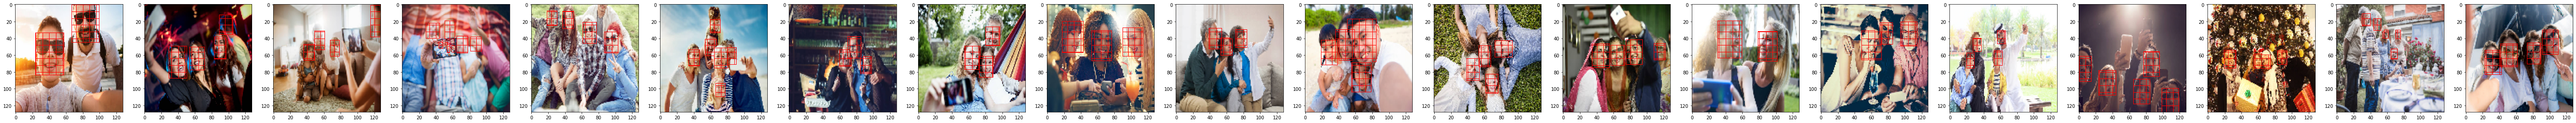

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
IMG_SIZE=128
testdatagen = ImageDataGenerator(rescale=1./255)
testcsv = pd.read_csv('drive/My Drive/Colab Notebooks/AnalyticsVidya/test.csv',dtype={'Name': str})
testgenerator = testdatagen.flow_from_dataframe(testcsv, directory='train/image_data/',x_col='Name', y_col=['Name'],
                                               target_size=(IMG_SIZE,IMG_SIZE), color_mode='rgb',class_mode='raw', batch_size=20,shuffle=True, seed=10)
model = build_model(IMG_SIZE,3)
model.load_weights('drive/My Drive/Colab Notebooks/AnalyticsVidya/FaceDetection/face_detectionTPU200_250.hdf5')
x_test,label_test = next(testgenerator)
p1,p2,p3,p4 = model.predict(x_test)
newp1 = np.reshape(p1,newshape=(p1.shape[0],int((IMG_SIZE*IMG_SIZE)/(8*8)),7))
newp2 = np.reshape(p2,newshape=(p2.shape[0],int((IMG_SIZE*IMG_SIZE)/(16*16)),7))
newp3 = np.reshape(p3,newshape=(p3.shape[0],int((IMG_SIZE*IMG_SIZE)/(32*32)),7))
newp4 = np.reshape(p4,newshape=(p4.shape[0],int((IMG_SIZE*IMG_SIZE)/(64*64)),7))
allanchorpred = np.hstack([newp1,newp2,newp3,newp4])
fig,ax = plt.subplots(1,20,figsize=(100,5))
for pi in range(1):
  img_to_show = x_test[pi]
  ax[pi].imshow(img_to_show)
  boxes = allanchorpred[pi][allanchorpred[pi][:,5]>1]
  boxes = boxes[boxes[:,4]>0.9]* IMG_SIZE
  print(pd.DataFrame(allanchorpred[pi]))
  for box in range(len(boxes)):
    ax[pi].add_patch(patches.Rectangle((boxes[box,0],boxes[box,1]),boxes[box,2]-boxes[box,0],boxes[box,3]-boxes[box,1],linewidth=1,edgecolor='b',facecolor='none'))
plt.show()

#### Harr Cascade test</b>

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image,ImageOps,ImageFilter
import matplotlib.patches as patches
import random
import cv2
from google.colab.patches import cv2_imshow

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
profile_cascade = cv2.CascadeClassifier('haarcascade_profileface.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
item_num = random.randint(0,(x_test[0].shape[0])-1)
#item_num = 24
img = Image.fromarray((x_test[3]).astype('uint8'),mode='RGB')
print(item_num)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ticks = np.arange(0, 256, 32)

ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.grid(b=True,color='black')
gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.01, 10)
for (x1,y1,w1,h1) in faces:
    print('x1 '+str(x1)+' y1 '+str(y1)+' w1 '+str(w1)+' h1 '+str(h1))
    img = cv2.rectangle(np.array(img),(x1,y1),(x1+w1,y1+h1),(255,0,0),2)
    roi_color = img[y1:y1+h1, x1:x1+w1]

profiles = profile_cascade.detectMultiScale(gray, 1.01, 10)
for (x2,y2,w2,h2) in profiles:
    print('x2 '+str(x2)+' y2 '+str(y2)+' w2 '+str(w2)+' h2 '+str(h2))
    img = cv2.rectangle(np.array(img),(x2,y2),(x2+w2,y2+h2),(0,255,0),2)
    roi_color = img[y2:y2+h2, x2:x2+w2]

ax.imshow(img)